In [ ]:
#@title
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/IS_Proekt

/content/drive/My Drive/IS_Proekt


In [ ]:
import numpy as np
import pandas as pd
from scipy.io import loadmat

Сите податоци со кои работевме се наоѓаат на следниот линк: https://drive.google.com/drive/folders/1azMZmC26TNLb5hXji4Tm3jiTlGbRunc4 (**orig_data** се оригиналните податоци од секој dataset (SBJ01-SBJ15) со 1200 колони и соодветен број на редици согласно множеството (без feature extraction), а **DWT** се екстрахираните податоци (со Discrete Wavelet Transform) од секој dataset (SBJ01-SBJ15) со 600 колони и соодветен број на редици согласно множеството)

**Фаза 2 - Претпроцесирање**

Првично, од .mat фајловите ја земаме низата со мерења и ја трансформираме на тој начин што самите настани (events) нѝ се редиците, додека сигналот се протега низ колоните, па така иницијално добивме 1600 редици со 2800 колони (8*350, значи за секоја електрода споено) за тренинг множествата, потоа 2800 колони со по 3600, 3200 и 3200 редици за секое од тест множествата соодветно. Овој пристап го направивме со цел полесно да можеме да пристапиме до сигналот за конкретен настан и истиот да го модифицираме по потреба.

Во описот на експериментот, наведено е дека должината на сигналот од EEG податоците е 1400ms (-200ms до 1200ms), при што тие првите 200ms (-200ms до 0ms) го претставуваат interstimulus интервалот (периодот помеѓу трепкање од еден до друг објект). P300 сигналот се јавува 250-500ms по светнување на објектот, а самото светење трае 100ms, така што ние во нашиот случај го земавме интервалот 0ms (како долна граница откако ќе заврши interstimulus периодот, односно потенцијално ќе започне со светкање новиот објект) до 600ms (како горна граница, во случај P300 да се јави 500ms по 100-те ms на светење на објектот) како интервал со потенцијален P300 сигнал.

Мерењата од електродите се поделени во 350 точки, така што земајќи го предвид фактот дека тие 350 точки ги репрезентираат 1400-те ms на сигналот, тоа би значело дека една точка претставува 4ms. Па така, првите 50 точки (индекси 0-49 се првите 200ms, односно оној interstimulus интервал (-200ms-0ms)) ги игнорираме, тргнуваме од 51-вата (индекс 50 -> 0ms), сѐ до 200-тата (600/4 = 150, пресметано од нулата, па мора да се додадат тие првите 50 од interstimulus интервалот, така што финално добиваме дека горната граница ќе ни е 200-тата колона -> индекс 199).

По извршената техника, нашите податоци содржат ист број на редици како горенаведените, додека бројот на колоните кај секое од множествата е 1200 (8*150, сигнал со должина 150 за секоја од електродите споено).

In [ ]:
# Функциите за генерирање на тренинг и тест множествата

# ВАЖНО: податоците се веќе изгенерирани, кодот стои како пример како сме ги добиле податоците,
# така што не треба повторно да се извршува!


def modify_train_data(dataset):
    input_files = [dataset + "/S01/Train/trainData.mat",
                   dataset + "/S02/Train/trainData.mat",
                   dataset + "/S03/Train/trainData.mat"]
    output_files = [dataset + "/trainData01Csv.csv",
                    dataset + "/trainData02Csv.csv",
                    dataset + "/trainData03Csv.csv"]

    for file_index in range(0, 3):
        mat_data = loadmat(input_files[file_index])
        mat_data = {k: v for k, v in mat_data.items() if k[0] != '_'}
        mat_data = np.array(mat_data['trainData'])

        data_len = len(mat_data[0][0])
        with open(output_files[file_index], 'x') as f1:
            for num in range(0, 1200):
                if num == 1199:
                    f1.write(str(num))
                else:
                    f1.write(str(num) + ',')
            f1.write('\n')
            for i in range(0, data_len):
                for j in range(0, 8):
                    for k in range(50, 200):
                        if j == 7 and k == 199:
                            f1.write(str(mat_data[j][k][i]))
                        else:
                            f1.write(str(mat_data[j][k][i]) + ',')
                f1.write('\n')


def modify_test_data(dataset):
    input_files = [dataset + "/S01/Test/testData.mat",
                   dataset + "/S02/Test/testData.mat",
                   dataset + "/S03/Test/testData.mat"]
    output_files = [dataset + "/testData01Csv.csv",
                    dataset + "/testData02Csv.csv",
                    dataset + "/testData03Csv.csv"]

    for file_index in range(0, 3):
        mat_data = loadmat(input_files[file_index])
        mat_data = {k: v for k, v in mat_data.items() if k[0] != '_'}
        mat_data = np.array(mat_data['testData'])

        data_len = len(mat_data[0][0])
        with open(output_files[file_index], 'x') as f1:
            for num in range(0, 1200):
                if num == 1199:
                    f1.write(str(num))
                else:
                    f1.write(str(num) + ',')
            f1.write('\n')
            for i in range(0, data_len):
                for j in range(0, 8):
                    for k in range(50, 200):
                        if j == 7 and k == 199:
                            f1.write(str(mat_data[j][k][i]))
                        else:
                            f1.write(str(mat_data[j][k][i]) + ',')
                f1.write('\n')

In [ ]:
# Генерирањето на тренинг и тест множествата

# ВАЖНО: податоците се веќе изгенерирани, кодот стои како пример како сме ги добиле податоците, така што не треба повторно да се извршува!

datasets = ["SBJ01", "SBJ02", "SBJ03", "SBJ04", "SBJ05", "SBJ06", "SBJ07", "SBJ08", "SBJ09", "SBJ10", "SBJ11", "SBJ12", "SBJ13",
            "SBJ14", "SBJ15"]
for dataset in datasets:
    modify_train_data(dataset)
    modify_test_data(dataset)

Во однос на останатиот дел од претпроцесирањето, ги проверивме сите податоци, нема missing values, нерелевантните информации ги отстранивме со изолацијата на конкретен фрагмент од сигналот како што е наведено погоре и дополнително, увидовме дека нема потреба од отстранување на аутлаери, поради тоа што не би знаеле дали еден податок се разликува од другите поради репрезентација на P300 сигнал, или поради тоа што навистина е аутлаер, па поради ризикот од губење на важни информации за тренирањето, одлучивме дека најдобро е овој чекор да не го направиме.

Следен важен чекор за нашите множества, односно за создавањето на нашиот feature vector, беше features extraction врз основа на податоците од EEG сигналите, бидејќи нашата мрежа не прима обични – raw податоци. Откривме дека најдобрата техника за feature extraction кога станува збор за EEG сигнали е Wavelet Transform (WT) методот. Тој всушност ги компресира тие временски-зависни сигнали во мали параметри кои соодветно го репрезентираат сигналот, притоа без да се губи информација, и со помош на тие едноставни трансформации, добиваме низа од db1 wavelet-и (Simple Wavelet Transform - тоа е доволно за нашиот проблем). Како резултат од применетата техника се добиваат две поднизи - cA (апроксимација) и cD (детали), од кои cD се токму оние wavelet коефициенти кои сакаме да ги искористиме.

In [ ]:
# Екстракција на features со Discrete Wavelet Transform - Функција за генерирање на фајловите
# source : https://pywavelets.readthedocs.io/en/0.2.2/ref/dwt-discrete-wavelet-transform.html

# ВАЖНО: податоците се веќе изгенерирани, кодот стои како пример како сме ги добиле податоците, така што не треба повторно да се извршува!

import csv
import pywt

def generate_dwt_train_files(dataset):
    orig_train_data = ["orig_data/" + dataset + "/trainData01Csv.csv",
                       "orig_data/" + dataset + "/trainData02Csv.csv",
                       "orig_data/" + dataset + "/trainData03Csv.csv"]
    out_train_data = ["DWT/" + dataset + "/trainData01Csv.csv",
                      "DWT/" + dataset + "/trainData02Csv.csv",
                      "DWT/" + dataset + "/trainData03Csv.csv"]
    for file_index in range(0, 3):
        line = []
        forCSV = []
        with open(orig_train_data[file_index]) as csvDataFile:
            csvReader = csv.reader(csvDataFile)
            i = 0
            for row in csvReader:

                if i == 0:
                    i += 1
                    continue  # za da ne se chitaat headerite

                line = row
                integerNiza = []
                for element in list(line[0:1200]):
                    ii = float(element)
                    integerNiza.append(ii)
                i += 1
                featureVectors = []

                # Wavelet Transform
                signal = []
                for x in range(0, 8):
                    lower_bound = x * 150
                    upper_bound = (x + 1) * 150
                    signal = integerNiza[lower_bound:upper_bound]
                    WT = pywt.dwt(signal, 'db1')[1]
                    for c in WT:
                        featureVectors.append(c)
                forCSV.append(featureVectors)

        a = np.asarray(forCSV)
        pd.DataFrame(a).to_csv(out_train_data[file_index], index=False)
        

def generate_dwt_test_files(dataset):
    orig_test_data = ["orig_data/" + dataset + "/testData01Csv.csv",
                      "orig_data/" + dataset + "/testData02Csv.csv",
                      "orig_data/" + dataset + "/testData03Csv.csv"]
    out_test_data = ["DWT/" + dataset + "/testData01Csv.csv",
                     "DWT/" + dataset + "/testData02Csv.csv",
                     "DWT/" + dataset + "/testData03Csv.csv"]
    for file_index in range(0, 3):
        line = []
        forCSV = []
        with open(orig_test_data[file_index]) as csvDataFile:
            csvReader = csv.reader(csvDataFile)
            i = 0
            for row in csvReader:

                if i == 0:
                    i += 1
                    continue  # za da ne se chitaat headerite

                line = row
                integerNiza = []
                for element in list(line[0:1200]):
                    ii = float(element)
                    integerNiza.append(ii)
                i += 1
                featureVectors = []

                # Wavelet Transform
                signal = []
                for x in range(0, 8):
                    lower_bound = x * 150
                    upper_bound = (x + 1) * 150
                    signal = integerNiza[lower_bound:upper_bound]
                    WT = pywt.dwt(signal, 'db1')[1]
                    for c in WT:
                        featureVectors.append(c)
                forCSV.append(featureVectors)

        a = np.asarray(forCSV)
        pd.DataFrame(a).to_csv(out_test_data[file_index], index=False)

In [ ]:
# Екстракција на features со Discrete Wavelet Transform - Генерирањето на самите фајлови

# ВАЖНО: податоците се веќе изгенерирани, кодот стои како пример како сме ги добиле податоците, така што не треба повторно да се извршува!

datasets = ["SBJ01", "SBJ02", "SBJ03", "SBJ04", "SBJ05", "SBJ06", "SBJ07", "SBJ08", "SBJ09", "SBJ10", "SBJ11", "SBJ12", "SBJ13",
            "SBJ14", "SBJ15"]
for dataset in datasets:
  generate_dwt_train_files(dataset)
  generate_dwt_test_files(dataset)

Она што преостана е визуелизација на самите податоци, па во следниов дел даваме табеларна и визуелна репрезентација на истите. Уште од самиот почеток, за да може добар увид да се има во податоците, првиот ред ни претставува ред со индекси, а понатаму се прикажани сигналите за секој од настаните.

In [ ]:
# Вчитување на потребните .csv фајлови (пред екстракцијата на features -> формат: 1600 редици, 1200 (8*150) колони)

trainData01Csv = pd.read_csv('orig_data/SBJ01/trainData01Csv.csv')

trainData01Csv # табеларен приказ на првото тренинг множество

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,1.923211,2.548195,1.360696,-0.687653,-2.543585,-3.580961,-3.745647,-3.363441,-2.999208,-3.350377,-4.854743,-7.316614,-10.016258,-12.072618,-12.698896,-11.439673,-8.387841,-4.131533,0.529406,4.815282,7.961993,9.349433,9.034744,7.876525,6.905389,6.667604,6.916784,6.774653,5.373833,2.492702,-1.283810,-4.901392,-7.465203,-8.795421,-9.402597,-9.880620,-10.457928,-11.089553,-11.669250,-11.973503,...,4.543873,5.597153,7.498377,10.749580,14.572690,17.552164,18.667969,17.616259,14.865598,11.432742,8.152751,5.354687,3.085684,1.207008,-0.301952,-0.934386,-0.043095,2.346296,5.366133,7.930150,9.280105,9.047167,7.431407,5.398217,4.308311,5.145172,7.967165,12.118072,16.839602,21.502148,25.513172,28.332838,29.489319,28.548958,25.471153,21.117815,16.910536,13.758245,11.770770,10.889406
1,1.513685,4.932230,7.859744,10.061305,11.409149,12.030107,12.214487,12.352330,12.743143,13.217808,13.041331,11.329113,7.676181,2.562298,-2.863137,-7.419174,-10.373942,-11.543057,-11.013053,-8.976391,-6.038758,-3.175963,-1.027144,0.423445,1.577205,2.961210,4.796582,6.610791,7.647965,7.546061,6.414060,4.657610,2.889384,1.533221,0.381569,-1.060234,-2.861142,-4.691035,-6.343222,-7.823515,...,6.570626,3.020256,-0.557487,-3.408213,-4.871566,-4.411081,-2.068373,1.233906,4.372591,6.937205,9.040509,10.509375,10.859080,9.763947,7.081467,2.877147,-2.174266,-6.726340,-9.295357,-9.076000,-6.595517,-3.573120,-2.045955,-3.305109,-7.048172,-11.489923,-14.682877,-15.843137,-15.605517,-15.371651,-16.236198,-18.203899,-20.404583,-21.931450,-22.417557,-22.034239,-21.066864,-19.701653,-18.391851,-17.786179
2,6.757680,6.937575,6.789161,6.016350,4.712034,3.287849,2.132312,1.400481,1.021581,0.731858,0.175591,-0.861743,-2.447176,-4.628164,-7.118992,-8.910501,-8.712559,-5.993649,-1.352651,4.078014,9.120225,12.704149,14.319794,14.233367,12.949626,10.853908,8.398214,6.091954,4.363573,3.580190,3.898577,4.986937,6.012312,6.102718,4.830689,2.283340,-0.840791,-3.199431,-3.363183,-0.631749,...,-1.689169,-1.419179,-0.964920,0.458770,2.720497,4.883620,5.841268,4.829732,1.659092,-3.070224,-7.698743,-10.138297,-9.376678,-6.022020,-1.582968,2.323980,4.627304,5.365439,5.561883,6.216552,7.498851,9.003863,10.370107,11.447987,12.113748,12.181087,11.584244,10.421267,8.714048,6.429578,3.834331,1.512505,-0.125034,-1.153830,-1.901767,-2.541993,-2.981215,-3.221977,-3.701021,-4.942334
3,18.147812,16.017044,11.573172,5.202446,-1.855014,-7.971526,-11.831251,-12.779704,-10.904072,-6.991653,-2.153976,2.711494,7.029565,10.291770,12.100816,12.411891,11.444782,9.569111,7.346778,5.388661,4.163850,3.796290,3.755316,2.977427,0.571277,-3.577926,-8.751716,-13.812018,-17.865307,-20.724327,-22.799274,-24.594696,-26.180891,-27.116547,-26.962149,-25.701490,-23.648169,-21.163588,-18.476387,-15.677548,...,2.566677,1.618232,-1.008048,-4.609138,-7.404531,-8.057834,-6.728110,-4.600194,-2.988380,-2.909883,-4.525075,-6.729021,-7.938218,-7.342190,-5.161569,-2.213860,0.331294,1.303032,0.148018,-2.671510,-5.753760,-7.425003,-6.801893,-4.467782,-2.025348,-0.722894,-0.435322,-0.078487,1.055355,2.661639,4.142702,5.423570,6.653667,7.565358,7.755593,7.335384,6.826268,6.735774,7.425040,8.970531
4,0.638877,-0.200988,-1.203759,-2.212728,-3.372553,-4.627010,-5.434200,-5.156588,-3.643818,-1.372661,0.903574,2.574706,3.283458,2.895568,1.672136,0.442140,0.236946,1.569182,4.177912,7.277114,9.859313,11.099742,10.877754,9.953730,9.424528,9.989543,11.742211,14.313340,17.085335,19.414051,20.734755,20.680574,19.184263,16.405725,12.739860,8.933435,5.872640,4.044909,3.313347,3.230069,...,2.715395,6.095548,9.273808,11.260723,11.857124,11.119555,9.180594,6.641801,4.329897,2.525689,1.026350,-0.057957,-0.334096,0.154899,0.997283,1.934790,2.911738,

In [ ]:
# Вчитување на потребните .csv фајлови (по екстракцијата на features -> формат: 1600 редици, 600 (8*75) колони (за секоја електрода се издвојуваат по 75 wavelet коефициенти))

trainData01Csv = pd.read_csv('DWT/SBJ01/trainData01Csv.csv')

trainData01Csv # табеларен приказ на првото тренинг множество

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599
0,-0.441930,1.448401,0.733536,-0.270260,0.248314,1.740806,1.454066,-0.890405,-3.009665,-3.030572,-0.981068,0.818985,0.168139,0.100502,2.037268,2.558017,0.940606,0.338013,0.446626,0.215140,-1.349350,-2.794489,-2.417276,-1.556739,-0.439084,-0.097470,-0.335639,1.210721,3.616062,3.221604,0.826689,-1.440138,-2.024302,-1.025721,-0.978640,-1.282839,0.072058,1.241998,0.958952,1.019509,...,-2.496525,-0.803169,0.464363,-0.316031,0.436068,2.080295,1.856945,1.010004,-0.033141,-2.759473,-3.145533,0.408483,1.350993,0.548469,1.118506,1.075446,-0.062690,0.038992,-0.585286,-1.219344,-0.744781,-2.298948,-2.106806,0.743671,2.427395,1.978530,1.328425,0.447199,-1.689554,-1.813034,0.164712,1.437683,-0.591750,-2.935134,-3.296918,-1.993805,0.664936,3.078275,2.229006,0.623218
1,-2.417276,-1.556739,-0.439084,-0.097470,-0.335639,1.210721,3.616062,3.221604,0.826689,-1.440138,-2.024302,-1.025721,-0.978640,-1.282839,0.072058,1.241998,0.958952,1.019509,1.293930,1.046725,0.562232,-0.472970,-2.252134,-2.482315,-0.698332,-0.018855,-0.127205,0.546460,1.007050,0.517482,0.204865,0.733506,1.542192,1.266788,-1.922559,-3.840060,-2.534217,0.061113,1.481897,1.630772,...,-2.106806,0.743671,2.427395,1.978530,1.328425,0.447199,-1.689554,-1.813034,0.164712,1.437683,-0.591750,-2.935134,-3.296918,-1.993805,0.664936,3.078275,2.229006,0.623218,-0.222273,1.104398,2.510491,2.015768,-0.325612,-2.335064,-1.813456,-1.038645,0.774377,2.972903,3.218803,-0.155108,-2.137157,0.890356,3.140793,0.820428,-0.165369,1.391375,1.079658,-0.271047,-0.965350,-0.428275
2,-0.127205,0.546460,1.007050,0.517482,0.204865,0.733506,1.542192,1.266788,-1.922559,-3.840060,-2.534217,0.061113,1.481897,1.630772,0.553935,-0.769586,-0.063926,1.801248,1.667810,-1.931416,-4.281616,-2.939231,-0.983958,0.561430,1.585221,0.917848,-0.265445,-0.664021,1.506680,4.504784,4.325027,0.670658,-2.766498,-3.440407,-2.306727,-0.219963,1.326300,1.384597,0.259905,0.550050,...,0.774377,2.972903,3.218803,-0.155108,-2.137157,0.890356,3.140793,0.820428,-0.165369,1.391375,1.079658,-0.271047,-0.965350,-0.428275,0.004591,-1.681922,-2.122390,-0.311244,-0.301161,-1.176909,-0.190911,-1.006701,-1.529559,0.715264,3.344132,1.725025,-2.372102,-2.762629,-0.521940,-0.462921,-1.064204,-0.762176,-0.047616,0.822349,1.615364,1.641779,0.727468,0.452708,0.170245,0.877741
3,1.506680,4.504784,4.325027,0.670658,-2.766498,-3.440407,-2.306727,-0.219963,1.326300,1.384597,0.259905,0.550050,2.933930,3.578174,2.021633,1.269555,0.661608,-0.891420,-1.756864,-1.979078,-1.861392,-1.507930,-1.217952,-0.758722,0.196238,0.709066,0.820120,0.570769,-1.069690,-1.609541,-0.501164,0.865097,0.145094,-1.844650,-1.825890,0.156969,0.374202,-1.239324,-1.960096,-0.933878,...,-0.521940,-0.462921,-1.064204,-0.762176,-0.047616,0.822349,1.615364,1.641779,0.727468,0.452708,0.170245,0.877741,1.599927,0.983167,-0.594834,-0.309894,-0.326612,-2.251979,-1.629100,-0.454126,0.670652,2.546355,0.461955,-1.504664,-0.055506,1.558425,-0.421455,-2.084345,-0.687122,1.993707,1.181747,-1.650466,-0.920974,-0.252320,-1.135814,-0.905710,-0.644663,0.297133,0.063989,-1.092828
4,0.593875,0.713449,0.887035,-0.196301,-1.605950,-1.181669,0.274279,0.869739,-0.942033,-2.191467,-0.877116,0.653384,-0.399526,-1.818063,-1.646651,0.038311,1.964723,2.691548,1.292401,0.058887,-0.052466,1.158250,3.135079,2.848332,0.345713,-1.475376,-1.443283,-1.898458,-2.629475,-1.509215,0.064881,1.635050,1.655190,0.818682,0.780573,1.766822,1.318563,-1.165143,-2.375698,-0.229260,...,1.142113,0.855031,-1.541932,-1.799696,0.816718,2.179480,-0.440605,-1.727062,-0.203344,-0.801747,-1.047269,-0.869810,-0.134517,0.359999,-0.487384,-1.429148,-0.339159,1.986702,2.368714,-0.167653,-2.390129,-1.404961,0.521541,1.795198,1.275768,0.766720,-0.345771,-0.662917,-0.829632,-1.817

Преостанува уште да се изврши визуелната репрезентација на оригиналните податоци (оние со 1600 редици и 1200 колони за тренинг множествата), па за истото ја искористивме библиотеката **mne**, која е наменета за приказ на вакви EEG сигнали.

In [ ]:
!pip install mne

     |████████████████████████████████| 6.6MB 3.4MB/s 


Creating RawArray with float64 data, n_channels=1600, n_times=1200
    Range : 0 ... 1199 =      0.000 ...     4.796 secs
Ready.


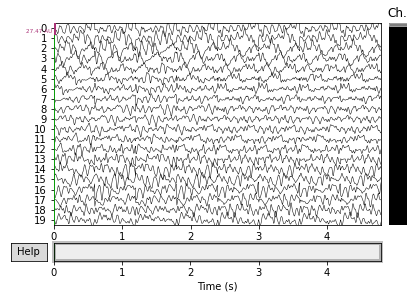

In [ ]:
# Визуелизација на оригиналните податоци

import mne

data = np.loadtxt('orig_data/SBJ01/trainData01Csv.csv', delimiter=',', skiprows=1)

# Some information about the channels
ch_names = []

for i in range(0, 1600):
    ch_names.append(str(i))

# Sampling rate of the Nautilus machine
sfreq = 250

# Create the info structure needed by MNE
info = mne.create_info(ch_names, sfreq)

# Finally, create the Raw object and plot it
raw = mne.io.RawArray(data, info).plot()

**Фаза 3 - Тренирање на нашата невронска мрежа - Deep Feed Forward**

Изборот на **Deep Feed Forward** мрежата произлезе од потребата за едноставна невронска мрежа, која на ефикасен начин ќе го испроцесира дадениот feature vector и со тоа ќе генерира соодветен output. Кај овој тип на мрежи информациите се движат строго нанапред (во една насока) од input слојот, до скриениот, па до output слојот, односно нема циклуси или лупи.

Кога станува збор за самото тренирање, нашата генерална идеја е следната: со одредена активациска функција, самата мрежа ќе ги испроцесира EEG податоците преку дадените feature vectors и ќе научи кој сигнал репрезентира постоење на P300 сигнал согласно 0 или 1 од trainTarget (ако бројчето за trainTarget е 0, значи тој сигнал не покажува присуство на P300, додека ако е 1, тогаш покажува присуство), и притоа ако тој сигнал има 1 за trainTarget (значи имало P300 сигнал), од trainEvent ќе види за кој објект станува збор (кој објект светнал). Во рамките на еден блок, би добиле низа од 10 бројки (10 runs - по една бројка (1-8) за секој run, потенцијален објект кој светнал) врз кои ќе се примени majority vote. Таа бројка (event/object) која ќе биде најприсутна ќе биде финалниот output од мрежата за тој блок-> trainLabel (значи мрежата ќе ни репродуцира 20 вакви лабели затоа што имаме 20 блока, ако го гледаме тренинг множеството). Потоа, ги споредуваме добиените 20 лабели со вистинските 20 лабели во trainLabels за да провериме колку ни била прецизна мрежата (притоа овде се прави некаков backpropagation на грешката и се вршат одредени модификации за подобрување на прецизноста). Откако мрежата ова ќе го научи да го процесира, ѝ го даваме тест множеството со feature vector составен од EEG сигнали и самата мрежа сега ќе знае да ги репродуцира 0 и 1 и за тој сигнал кој би дал 1, ќе провери кој trainEvent е во таа редица, при што истиот ќе го даде како резултат. Податокот во runs_per_block ќе ни каже кога треба да запреме и да направиме majority vote за да видиме кој таргет го предвидела нашата мрежа за тој конкретен блок. Како output треба да добиеме 50 вакви таргет лабели (ако го гледаме тест множеството), кои потоа во четвртата фаза ќе ги споредиме со реалните таргет лабели за тест множествата и ќе можеме да заклучиме колку нашата мрежа е прецизна во предвидувањето.

Принципот на majority vote функционира на следниов начин: во дадената низа од targets ги бара единиците и онаму каде што има поклопување, во runs го запишува настанот кој trigger-нал 1 (односно предизвикал P300 сигнал). Во низата runs секогаш чуваме 10 вакви податоци (или во зависност од runs_per_block параметарот), па штом ги најде сите 10 настани од првиот блок кои предизвикале P300, врз нив врши majority voting (го бира оној кој најчесто се јавува, со помош на функцијата mode од statistics) и резултатите ги запишува во target_labels низата, односно тоа е реалниот output кој треба да го добиеме од нашата мрежа (предвидувањето за тоа кој објект бил таргет во секој од соодветните блокови). Значи, штом ги добиеме изгенерираните 0 и 1 од невронската мрежа, со оваа функција веднаш ќе го добиеме потребниот output.

In [ ]:
# Majority voting функција (за да работи точно мора да има 7 нули и 1 единица во рамките на еден run)

from statistics import mode
import collections
import array
import random

# targets - nizata generirana od nashata mrezha (0 i 1)
# events - niza od events za sekoja sesija (gi ima kako txt fajlovi i vo train i vo test)
# runs_per_block - za train sekade e 10, a za test ima definirano brojche vo soodvetniot txt fajl
def generate_labels(targets, events, runs_per_block):
    if len(targets) != len(events):
        print("Targets and events should be of the same size!")
        return
    print("Runs per block: ", runs_per_block)
    runs = []
    target_labels = []
    stop_counter = 1    # zapira na sekoi 8*runs_per_block za da presmeta koj objekt najvekje pati se pojavil vo ramkite na toj blok
    for i in range(0, len(targets)):
        if targets[i] == 1:
            runs.append(events[i])
        if i == (8 * runs_per_block * stop_counter) - 1:
            runs = _counts(runs)
            if runs: # ako ima barem edna edinica, vrati go najchestiot objekt
              target_labels.append(int(runs[0][0]))
            else:    # no, ako ne se predvidela niedna edinica, vrati random broj od 1 do 8 (random objekt)
              target_labels.append(random.randrange(1, 8))
            runs = []
            stop_counter += 1
    return target_labels


def _counts(data):
    # Generate a table of sorted (value, frequency) pairs.
    table = collections.Counter(iter(data)).most_common()
    if not table:
        return table
    # Extract the values with the highest frequency.
    maxfreq = table[0][1]
    for i in range(1, len(table)):
        if table[i][1] != maxfreq:
            table = table[:i]
            break
    return table


# Usage
train_targets = []
f = open("DWT/SBJ01/trainTargets01.txt", 'r')
for line in f:
    train_targets.append(int(line.strip()))
f.close()

train_events = []
f = open("DWT/SBJ01/trainEvents01.txt", 'r')
for line in f:
    train_events.append(int(line.strip()))
f.close()

print(generate_labels(train_targets, train_events, 10))

# Проверка
train_labels = np.loadtxt('DWT/SBJ01/trainLabels01.txt', delimiter=',')
print(train_labels) # ги чува како 5.0, 8.0 ... па затоа има точки

Runs per block:  10
[6, 5, 8, 6, 5, 1, 5, 4, 7, 3, 4, 3, 6, 6, 8, 7, 3, 2, 4, 3]
[6. 5. 8. 6. 5. 1. 5. 4. 7. 3. 4. 3. 6. 6. 8. 7. 3. 2. 4. 3.]


За градење на невронската мрежа истраживме повеќе технологии, од кои го одбравме Keras. (https://keras.io/).

Оваа библиотека се заснова на други back-end технологии, од кои најпознати се TensorFlow и Theano.
Keras е многу едноставна алатка, која има голем број вградени функции кои го олеснуваат самиот процес на градење и тренирање на невронските мрежи. 

Градењето на модел преку Keras се започнува со функцијата model = Sequential(), која што означува иницијализација на секвенцијален модел, за кој дефиниран е еден input слој и еден output слој. Помеѓу двата, може да има голем број на скриени слоеви што ние ќе ги дефинираме.


Потоа, со model.add се додава секој нареден слој во моделот. Во секој слој треба да се специфицираат неколку параметри, како бројот на неврони, и секако активациската функција. Во некои слоеви, како на пример на input слојот, треба да се дефинира и формата на инпутот.


Двете активациски функции кои ние ги искористивме за оваа фаза се ReLU и Sigmoid. Во контекст на вештачки невронски мрежи, ReLU е активациска функција дефинирана како позитивен дел од нејзиниот аргумент: каде x е влезот во неврон. Често е користена во скриените слоеви на мрежите, и се препорачува да се користи. Sigmoid во нашиот модел беше искористена во последниот слој т.е. за output-от, бидејќи е добар избор за класифицирање на output-от во 0 или 1.


При компајлирањето на моделот, потребен е optimizer. Има неколку различни видови на optimizers, во овој случај во кодот е поставен Adam. Исто така, може да се додадат некои дополнителни параметри, како на пример метриката (во овој случај точноста) и мерката за загуба (loss).


Откако ќе се изврши model.compile, конечно можеме да направиме fit на нашите податоци, преку функцијата model.fit. Таа го прима множеството X на тренинг податоци, множеството на Y на класата (нула или единица), а дополнително прима и аргументи за batch size и за тоа колку епохи ние сакаме да ја тренираме мрежата.




In [ ]:
import numpy as np, pandas
from scipy.io import loadmat
import matplotlib.pyplot as plt
import mne
import tensorflow
from keras.models import Sequential
from keras.layers import Dense,LSTM, Dropout
from keras import initializers
import keras
import theano
import math

In [ ]:
# Градење на моделот

baseline_model = Sequential()
baseline_model.add(Dense(4, input_dim=600, activation='relu'))  # прв слој со 4 јазли, зема 600 inputs и користи активациска функција ReLU
baseline_model.add(Dropout(0.5)) # се користи да се исфрлат 0.5 - 50% од outputs од претходниот слој за да се спречи overfitting и да се додаде шум во моделот
baseline_model.add(Dense(4, activation='relu'))
baseline_model.add(Dropout(0.5))
baseline_model.add(Dense(1, activation='sigmoid'))
# последниот слој има 1 јазол и сигмоид активациска функција за да добиеме output помеѓу 0 и 1, кој потоа можеме да го заокружиме и да ги добиеме потребните trainTargets

baseline_model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])  # компајлирање на моделот, binary crossentropy бидејќи класифицираме (0 и 1 за trainTargets)

baseline_model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 4)                 2404      
_________________________________________________________________
dropout_100 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_155 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_101 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_156 (Dense)            (None, 1)                 5         
Total params: 2,429
Trainable params: 2,429
Non-trainable params: 0
_________________________________________________________________


Пред да започнеме со самото тренирање, потребно е да го поделиме тренинг множеството на training_set и validation_set за да провериме дали успешно предвидува нашата мрежа и дали има потреба од некакви модификации. Добра пракса е да се искористи 75%:25% сооднос помеѓу тренинг и валидациско множество, па истото го направивме и во нашиот случај, користејќи го кодот:

In [ ]:
# Вчитување на податоците од SBJ01 и нивна поделба на X и Y тренинг и валидациски множества
datasets = ["SBJ01", "SBJ02", "SBJ03", "SBJ04", "SBJ05", "SBJ06", "SBJ07", "SBJ08", "SBJ09", "SBJ10", "SBJ11", "SBJ12", "SBJ13",
            "SBJ14", "SBJ15"]
final_targets = []

for dataset in datasets:

  train_data01 = np.loadtxt("DWT/" + dataset + "/trainData01Csv.csv", delimiter=',', skiprows=1)
  train_data02 = np.loadtxt("DWT/" + dataset + "/trainData02Csv.csv", delimiter=',', skiprows=1)
  train_data03 = np.loadtxt("DWT/" + dataset + "/trainData03Csv.csv", delimiter=',', skiprows=1)

  train_targets01 = np.loadtxt("DWT/" + dataset + "/trainTargets01.txt")
  train_targets02 = np.loadtxt("DWT/" + dataset + "/trainTargets02.txt")
  train_targets03 = np.loadtxt("DWT/" + dataset + "/trainTargets03.txt")

  X_TRAIN_01 = train_data01[0:math.ceil(0.75 * len(train_data01))]
  X_TRAIN_02 = train_data02[0:math.ceil(0.75 * len(train_data02))]
  X_TRAIN_03 = train_data03[0:math.ceil(0.75 * len(train_data03))]
  X_VAL_01 = train_data01[math.ceil(0.75 * len(train_data01)):]
  X_VAL_02 = train_data02[math.ceil(0.75 * len(train_data02)):]
  X_VAL_03 = train_data03[math.ceil(0.75 * len(train_data03)):]

  Y_TRAIN_01 = train_targets01[0:math.ceil(0.75 * len(train_targets01))]
  Y_TRAIN_02 = train_targets02[0:math.ceil(0.75 * len(train_targets02))]
  Y_TRAIN_03 = train_targets03[0:math.ceil(0.75 * len(train_targets03))]
  Y_VAL_01 = train_targets01[math.ceil(0.75 * len(train_targets01)):]
  Y_VAL_02 = train_targets02[math.ceil(0.75 * len(train_targets02)):]
  Y_VAL_03 = train_targets03[math.ceil(0.75 * len(train_targets03)):]

  test_data01 = np.loadtxt("DWT/" + dataset + "/testData01Csv.csv", delimiter=',', skiprows=1)
  test_data02 = np.loadtxt("DWT/" + dataset + "/testData02Csv.csv", delimiter=',', skiprows=1)
  test_data03 = np.loadtxt("DWT/" + dataset + "/testData03Csv.csv", delimiter=',', skiprows=1)

  # Градење на моделот

  baseline_model = Sequential()
  baseline_model.add(Dense(4, input_dim=600, activation='relu'))  # прв слој со 4 јазли, зема 600 inputs и користи активациска функција ReLU
  baseline_model.add(Dropout(0.5)) # се користи да се исфрлат 0.5 - 50% од outputs од претходниот слој за да се спречи overfitting и да се додаде шум во моделот
  baseline_model.add(Dense(4, activation='relu'))
  baseline_model.add(Dropout(0.5))
  baseline_model.add(Dense(1, activation='sigmoid'))
  # последниот слој има 1 јазол и сигмоид активациска функција за да добиеме output помеѓу 0 и 1, кој потоа можеме да го заокружиме и да ги добиеме потребните trainTargets

  baseline_model.compile(loss='binary_crossentropy', optimizer='adam',
                metrics=['accuracy'])  # компајлирање на моделот, binary crossentropy бидејќи класифицираме (0 и 1 за trainTargets)
  
  # Fitting на моделот - S01
  baseline_model.fit(np.array(X_TRAIN_01), 
                     Y_TRAIN_01, 
                     batch_size=64, 
                     epochs=30, 
                     validation_data=(X_VAL_01, Y_VAL_01), 
                     verbose=0)

  # евалуација на прецизноста на моделот
  print("loss ->", 
        baseline_model.evaluate(np.array(X_TRAIN_01), Y_TRAIN_01), "<- accuracy")

  # предвидувања
  predictions = baseline_model.predict(np.array(test_data01))

  # генерирање на финалните лабели
  network_targets = []
  for p in predictions:
    if p < 0.2:
      network_targets.append(0)
    else:
      network_targets.append(1)

  # генерирање на таргет лабелите
  test_events = np.loadtxt("DWT/" + dataset + "/testEvents01.txt")
  runs_per_block = np.loadtxt("DWT/" + dataset + "/runs_per_block01.txt")
  final_targets.append(
      generate_labels(network_targets, test_events, int(runs_per_block)))



  # Fitting на моделот - S02
  baseline_model.fit(np.array(X_TRAIN_02), Y_TRAIN_02, batch_size=64, epochs=30, validation_data=(X_VAL_02, Y_VAL_02), verbose=0)

  # евалуација на прецизноста на моделот
  print("loss ->", baseline_model.evaluate(np.array(X_TRAIN_02), Y_TRAIN_02), "<- accuracy")

  # предвидувања
  predictions = baseline_model.predict(np.array(test_data02))

  # генерирање на финалните лабели
  network_targets = []
  for p in predictions:
    # final_targets.append(int(np.round(p)))
    if p < 0.2:
      network_targets.append(0)
    else:
      network_targets.append(1)

  # генерирање на таргет лабелите
  test_events = np.loadtxt("DWT/" + dataset + "/testEvents02.txt")
  runs_per_block = np.loadtxt("DWT/" + dataset + "/runs_per_block02.txt")
  final_targets.append(generate_labels(network_targets, test_events, int(runs_per_block)))



  # Fitting на моделот - S03
  baseline_model.fit(np.array(X_TRAIN_03), Y_TRAIN_03, batch_size=64, epochs=30, validation_data=(X_VAL_03, Y_VAL_03), verbose=0)

  # евалуација на прецизноста на моделот
  print("loss ->", baseline_model.evaluate(np.array(X_TRAIN_03), Y_TRAIN_03), "<- accuracy")

  # предвидувања
  predictions = baseline_model.predict(np.array(test_data03))

  # генерирање на финалните лабели
  network_targets = []
  for p in predictions:
    # final_targets.append(int(np.round(p)))
    if p < 0.2:
      network_targets.append(0)
    else:
      network_targets.append(1)

  # генерирање на таргет лабелите
  test_events = np.loadtxt("DWT/" + dataset + "/testEvents03.txt")
  runs_per_block = np.loadtxt("DWT/" + dataset + "/runs_per_block03.txt")
  final_targets.append(generate_labels(network_targets, test_events, int(runs_per_block)))


  keras.backend.clear_session() # reset на моделот, за да имаме независно тестирање за секој субјект посебно

1200/1200 [==============================] - 0s 24us/step
loss -> [0.3105226449171702, 0.875] <- accuracy
Runs per block:  6
1200/1200 [==============================] - 0s 24us/step
loss -> [0.303374871412913, 0.875] <- accuracy
Runs per block:  7
1200/1200 [==============================] - 0s 25us/step
loss -> [0.31173097133636474, 0.875] <- accuracy
Runs per block:  7
1200/1200 [==============================] - 0s 23us/step
loss -> [0.28728431860605874, 0.875] <- accuracy
Runs per block:  9
1200/1200 [==============================] - 0s 22us/step
loss -> [0.2949386441707611, 0.875] <- accuracy
Runs per block:  8
1200/1200 [==============================] - 0s 26us/step
loss -> [0.2846455987294515, 0.875] <- accuracy
Runs per block:  5
1200/1200 [==============================] - 0s 27us/step
loss -> [0.3727172740300496, 0.875] <- accuracy
Runs per block:  6
1200/1200 [==============================] - 0s 29us/step
loss -> [0.324849396944046, 0.875] <- accuracy
Runs per block:  6


In [ ]:
for f in final_targets:
  if (len(f) != 50):
    print("Потребно е да се генерираат точно 50 таргет лабели!")
    break
print(final_targets)

45
[[8, 1, 1, 1, 6, 2, 6, 4, 8, 1, 8, 6, 1, 1, 1, 5, 2, 6, 7, 1, 4, 1, 7, 3, 5, 6, 8, 3, 2, 1, 7, 6, 8, 6, 8, 4, 7, 8, 7, 1, 6, 6, 3, 4, 8, 1, 8, 2, 5, 7], [3, 5, 8, 3, 6, 2, 6, 6, 6, 2, 4, 6, 6, 6, 5, 6, 2, 4, 7, 4, 4, 3, 7, 7, 3, 8, 8, 1, 7, 6, 4, 8, 4, 1, 1, 1, 2, 1, 8, 7, 1, 4, 3, 2, 6, 5, 8, 2, 2, 8], [3, 3, 1, 8, 7, 1, 7, 3, 7, 2, 1, 8, 7, 8, 7, 4, 8, 1, 3, 6, 7, 4, 6, 3, 3, 8, 4, 4, 5, 2, 4, 6, 6, 4, 6, 4, 8, 3, 7, 8, 2, 6, 4, 7, 4, 7, 8, 5, 4, 3], [6, 4, 1, 2, 6, 7, 3, 4, 5, 7, 1, 6, 1, 3, 4, 8, 3, 1, 6, 1, 4, 8, 6, 8, 5, 3, 7, 1, 1, 3, 1, 6, 5, 3, 3, 1, 1, 7, 6, 3, 4, 7, 7, 4, 6, 4, 2, 7, 7, 8], [7, 7, 3, 3, 1, 3, 3, 1, 2, 4, 6, 6, 7, 8, 2, 2, 2, 2, 6, 3, 6, 5, 2, 1, 1, 6, 1, 7, 1, 4, 3, 1, 5, 2, 8, 2, 5, 6, 6, 7, 2, 3, 1, 6, 5, 8, 3, 4, 7, 8], [2, 5, 3, 4, 7, 6, 6, 3, 4, 1, 4, 8, 8, 3, 6, 7, 1, 2, 6, 6, 4, 1, 1, 5, 1, 1, 3, 6, 7, 1, 6, 3, 4, 5, 3, 1, 2, 2, 6, 1, 8, 6, 4, 3, 2, 2, 7, 1, 6, 7], [1, 6, 7, 3, 4, 2, 3, 4, 4, 2, 6, 6, 2, 6, 1, 1, 6, 8, 6, 7, 8, 5, 1, 6, 5, 7, 8, 3,

In [ ]:
pd.DataFrame(final_targets).to_csv("final_output.csv", index=False) # финалниот output на нашата мрежа

In [ ]:
import matplotlib.pyplot as plt

# baseline loss
plt.plot(baseline_history.history['accuracy'])
plt.plot(baseline_history.history['loss'])
plt.plot(baseline_history.history['val_loss'])
plt.title('baseline model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# baseline accuracy
plt.plot(baseline_history.history['accuracy'])
plt.plot(baseline_history.history['val_accuracy'])
plt.title('baseline model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()